In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, ReLU, add, GlobalAveragePooling2D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir train
! unzip -qq /content/drive/MyDrive/dataproject/archive.zip -d train

In [ ]:
image_paths = []
image_texts = []

data_folder = "train/dataset"

for path in os.listdir(data_folder):
    image_paths.append(data_folder + "/" + path)
    image_texts.append(path.split(".")[0])

In [ ]:
image_paths[:10], image_texts[:10]

(['train/dataset/39463.jpg',
  'train/dataset/03846.jpg',
  'train/dataset/855523.jpg',
  'train/dataset/1450159.jpg',
  'train/dataset/82295.jpg',
  'train/dataset/7624562.jpg',
  'train/dataset/629155.jpg',
  'train/dataset/200232.jpg',
  'train/dataset/5000653.jpg',
  'train/dataset/024608.jpg'],
 ['39463',
  '03846',
  '855523',
  '1450159',
  '82295',
  '7624562',
  '629155',
  '200232',
  '5000653',
  '024608'])

In [ ]:
corrupt_images = []

for path in image_paths:
    try:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    except:
        corrupt_images.append(path)

In [ ]:
corrupt_images, len(corrupt_images)

([], 0)

In [ ]:
### get vocabulary for the current dataset
vocab = set("".join(map(str, image_texts)))
print(sorted(vocab))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
max_label_len = max([len(str(text)) for text in image_texts])
max_label_len

7

In [ ]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

In [ ]:
padded_image_texts = list(map(encode_to_labels, image_texts))
print(padded_image_texts[0])
print(image_texts[0])

[ 3  9  4  6  3 10 10]
39463


In [ ]:
train_image_paths = image_paths[ : int(len(image_paths) * 0.90)]
train_image_texts = padded_image_texts[ : int(len(image_texts) * 0.90)]

val_image_paths = image_paths[int(len(image_paths) * 0.90) : ]
val_image_texts = padded_image_texts[int(len(image_texts) * 0.90) : ]

In [ ]:
def process_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [64, 306])
    return {"image": img, "label": label}


In [ ]:
process_single_sample(f'train/dataset/{image_texts[0]}.jpg', image_texts[0])

{'image': <tf.Tensor: shape=(64, 306, 1), dtype=float32, numpy=
 array([[[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],
 
        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.9686275 ],
         [1.        ],
         [1.        ]],
 
        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.98823535],
         [1.        ],
         [1.        ]],
 
        ...,
 
        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],
 
        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],
 
        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.     

In [ ]:
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_texts))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_texts))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

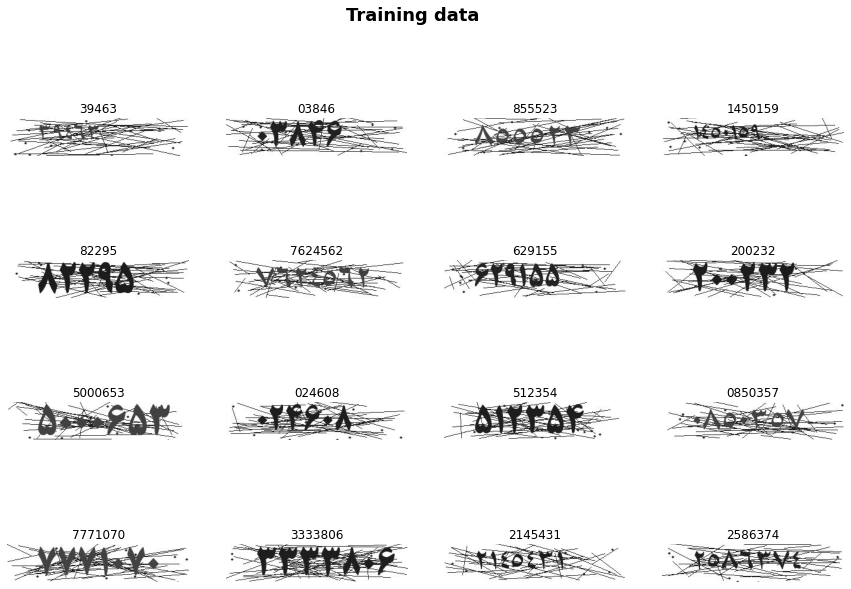

In [ ]:
# Mapping characters to integers
# char_to_num = layers.experimental.preprocessing.StringLookup(
#     vocabulary=char_list, num_oov_indices=0, mask_token=None
# )

# Mapping integers back to original characters
# num_to_char = layers.experimental.preprocessing.StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
# )

train_data_fig, ax = plt.subplots(4, 4, figsize=(15, 10))
train_data_fig.suptitle('Training data', weight='bold', size=18)


for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = labels[i].numpy()
        label = ''.join(str(x) for x in label if x != 10)

        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    
plt.show()

In [ ]:
## Ref: https://keras.io/examples/vision/captcha_ocr/

class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [ ]:
figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = validation_dataset.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)

        orig_texts = []

        for label in self.batch_labels:
            orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :, 0] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()
        #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)

In [ ]:
def train(epochs):
    
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(64, 306, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_6)
    batch_norm_7 = BatchNormalization()(conv_7)
    pool_7 = MaxPool2D(pool_size=(2, 1))(batch_norm_7)
    
    conv_8 = Conv2D(64, (2,2), activation = "selu")(pool_7)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_8)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)


    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    #model to be used at training time
    model = Model(inputs=[inputs, labels], outputs=output)
    model.compile(optimizer = optimizer)

    print(model.summary())
    file_path = "C_LSTM_best.hdf5"
    
    checkpoint = ModelCheckpoint(filepath=file_path, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='min')

    callbacks_list = [checkpoint, 
                      PlotPredictions(frequency=1),
                      EarlyStopping(patience=3, verbose=1)]

    history = model.fit(train_dataset, 
                        epochs = epochs,
                        validation_data=validation_dataset,
                        verbose = 1,
                        callbacks = callbacks_list,
                        shuffle=True)
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 306, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 306, 32)  320         ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 153, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 153, 64)  18496       ['max_pooling2d[0][0]']      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 9.4396
Epoch 1: val_loss improved from inf to 19.89629, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 1s 18ms/step


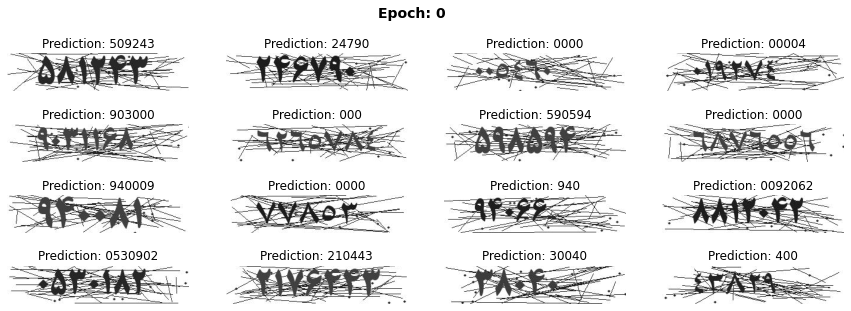

106/106 [==============================] - 83s 588ms/step - loss: 9.4396 - val_loss: 19.8963
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.0336
Epoch 2: val_loss improved from 19.89629 to 2.25215, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 1s 18ms/step


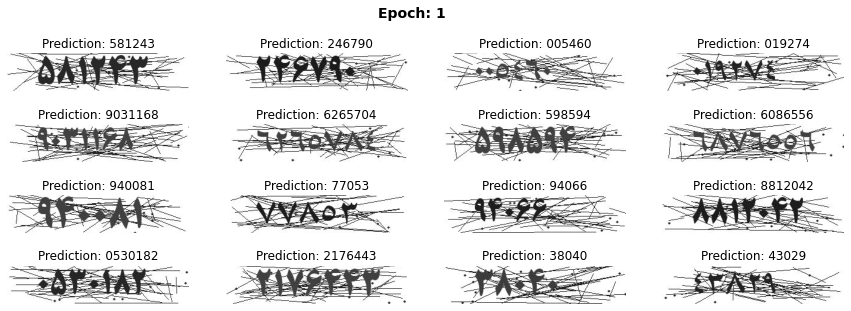

106/106 [==============================] - 58s 540ms/step - loss: 0.0336 - val_loss: 2.2522
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.0159
Epoch 3: val_loss improved from 2.25215 to 0.38772, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 1s 19ms/step


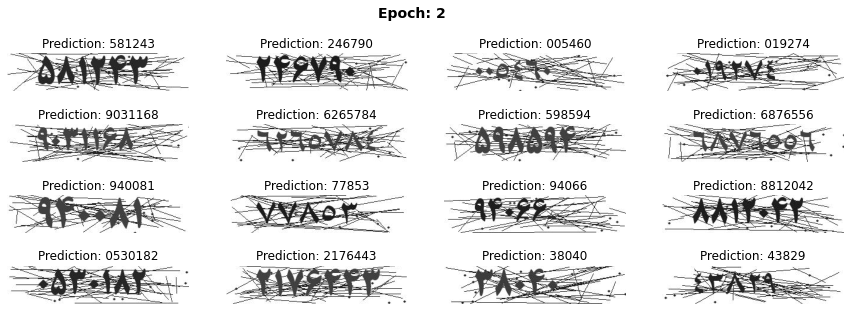

106/106 [==============================] - 57s 532ms/step - loss: 0.0159 - val_loss: 0.3877
Epoch 4/30
106/106 [==============================] - ETA: 0s - loss: 0.0091
Epoch 4: val_loss did not improve from 0.38772
8/8 [==============================] - 1s 19ms/step


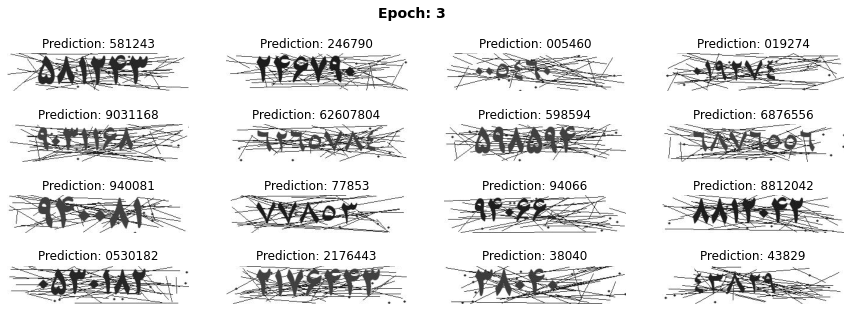

106/106 [==============================] - 57s 540ms/step - loss: 0.0091 - val_loss: 1.2699
Epoch 5/30
106/106 [==============================] - ETA: 0s - loss: 0.0056
Epoch 5: val_loss improved from 0.38772 to 0.01523, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 1s 19ms/step


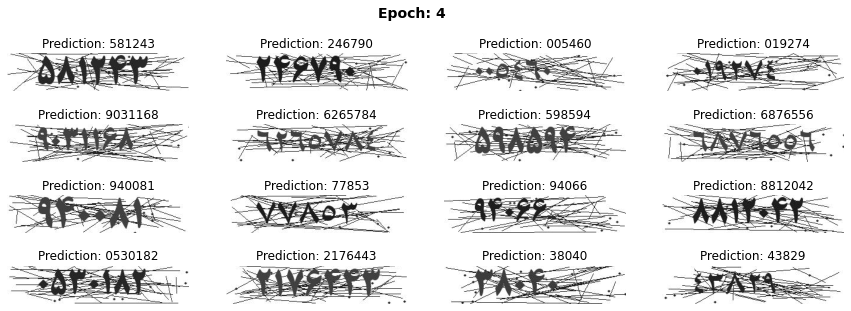

106/106 [==============================] - 57s 540ms/step - loss: 0.0056 - val_loss: 0.0152
Epoch 6/30
106/106 [==============================] - ETA: 0s - loss: 0.0043
Epoch 6: val_loss did not improve from 0.01523
8/8 [==============================] - 1s 20ms/step


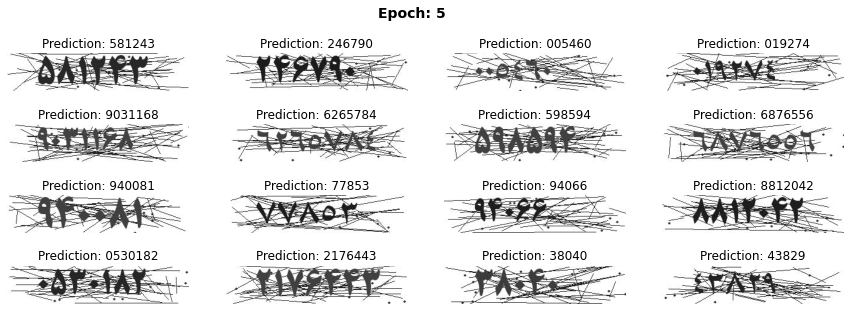

106/106 [==============================] - 58s 545ms/step - loss: 0.0043 - val_loss: 0.0500
Epoch 7/30
106/106 [==============================] - ETA: 0s - loss: 0.0047
Epoch 7: val_loss improved from 0.01523 to 0.00741, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 1s 21ms/step


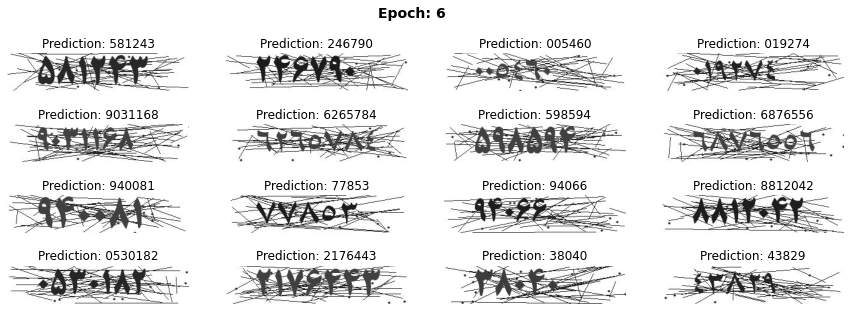

106/106 [==============================] - 59s 559ms/step - loss: 0.0047 - val_loss: 0.0074
Epoch 8/30
106/106 [==============================] - ETA: 0s - loss: 0.0041
Epoch 8: val_loss did not improve from 0.00741
8/8 [==============================] - 1s 19ms/step


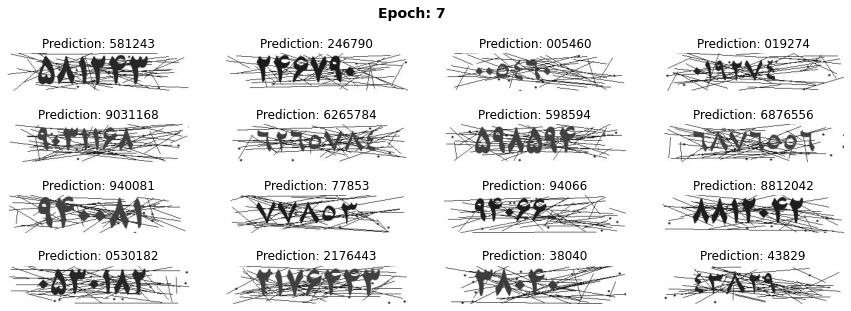

106/106 [==============================] - 58s 543ms/step - loss: 0.0041 - val_loss: 0.1223
Epoch 9/30
106/106 [==============================] - ETA: 0s - loss: 0.0017
Epoch 9: val_loss did not improve from 0.00741
8/8 [==============================] - 1s 20ms/step


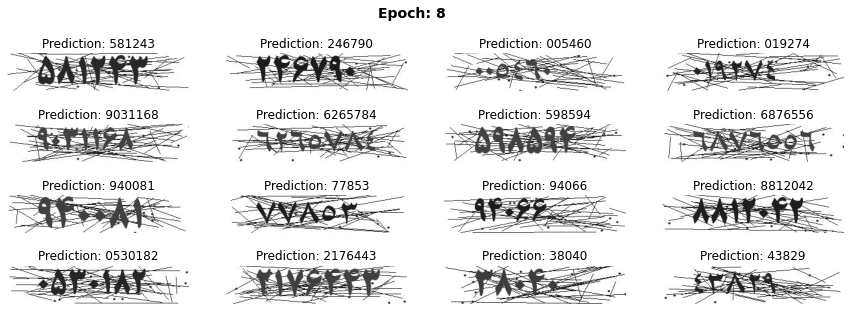

106/106 [==============================] - 58s 543ms/step - loss: 0.0017 - val_loss: 0.0530
Epoch 10/30
106/106 [==============================] - ETA: 0s - loss: 8.0033e-04
Epoch 10: val_loss did not improve from 0.00741
8/8 [==============================] - 1s 20ms/step


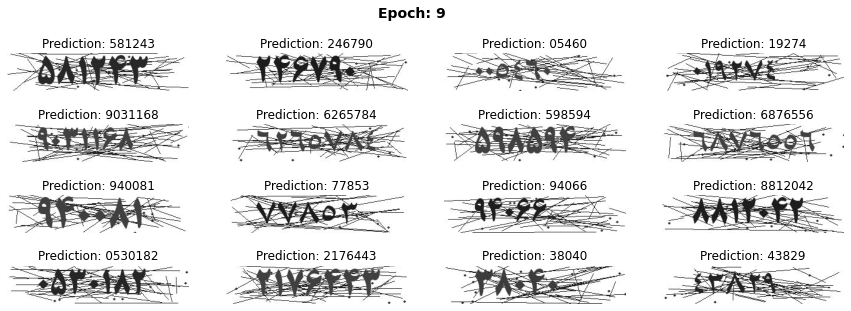

106/106 [==============================] - 60s 561ms/step - loss: 8.0033e-04 - val_loss: 0.0434
Epoch 10: early stopping


In [ ]:
model = train(epochs=30)

In [ ]:
model.load_weights('C_LSTM_best.hdf5')

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense").output
)
prediction_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 64, 306, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 306, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 153, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 153, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 76, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 76, 128)       738

In [ ]:
len(figures_list)

10

8/8 [==============================] - 1s 28ms/step


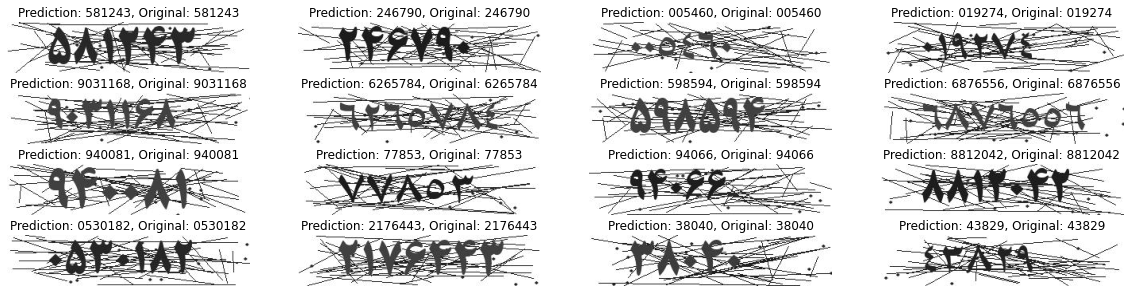

In [ ]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):

    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        a = label.numpy()
        a = ''.join(str(x) for x in a if x != 10)
        orig_texts.append(a)

    fig , ax = plt.subplots(4, 4, figsize=(20, 5))
    for i in range(16):

        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        title = f"Prediction: {pred_texts[i]}, Original: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
plt.show()